In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Generate simple random dataset

In [2]:
print("Train:")
X_train = np.random.rand(1000, 20)
y_train = np.random.randint(low=0, high=2, size=(1000, 2))

print(X_train.shape)
print(y_train.shape)

print("\nTest:")
X_val = np.random.rand(200, 20)
y_val = np.random.randint(low=0, high=2, size=(200, 2))

print(X_val.shape)
print(y_val.shape)

Train:
(1000, 20)
(1000, 2)

Test:
(200, 20)
(200, 2)


In [3]:
def getTensorDataset(my_x, my_y):
    tensor_x = torch.Tensor(my_x)
    tensor_y = torch.Tensor(my_y).long()
    return torch.utils.data.TensorDataset(tensor_x, tensor_y)

train_loader = DataLoader(dataset=getTensorDataset(X_train, y_train), batch_size=50)
val_loader = DataLoader(dataset=getTensorDataset(X_val, y_val), batch_size=50)

### Define the model

In [4]:
class Expert(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # self.log_soft = nn.LogSoftmax(1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.log_soft(out)
        return out
    
class Tower(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Tower, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        return out

In [5]:
class MMOE(torch.nn.Module):
    def __init__(self, input_size, num_experts, experts_out, experts_hidden, towers_hidden, tasks):
        super(MMOE, self).__init__()
        # params
        self.input_size = input_size
        self.num_experts = num_experts
        self.experts_out = experts_out
        self.experts_hidden = experts_hidden
        self.towers_hidden = towers_hidden
        self.tasks = tasks
        # row by row
        self.softmax = nn.Softmax(dim=1)
        # model
        self.experts = nn.ModuleList([Expert(self.input_size, self.experts_out, self.experts_hidden) for i in range(self.num_experts)])
        self.w_gates = nn.ParameterList([nn.Parameter(torch.randn(input_size, num_experts), requires_grad=True) for i in range(self.tasks)])
        self.towers = nn.ModuleList([Tower(self.experts_out, 2, self.towers_hidden) for i in range(self.tasks)])

    def forward(self, x):
        # get the experts output
        expers_o = [e(x) for e in self.experts]
        expers_o_tensor = torch.stack(expers_o)
        
        # get the gates output
        gates_o = [self.softmax(x @ g) for g in self.w_gates]
        
        # multiply the output of the experts with the corresponding gates output
        # res = gates_o[0].t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor
        # https://discuss.pytorch.org/t/element-wise-multiplication-of-the-last-dimension/79534
        towers_input = [g.t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor for g in gates_o]
        towers_input = [torch.sum(ti, dim=0) for ti in towers_input]
        
        # get the final output from the towers
        final_output = [t(ti) for t, ti in zip(self.towers, towers_input)]
        
        # get the output of the towers, and stack them
        final_output = torch.stack(final_output, dim=1)
        
        return final_output

In [6]:
simple_input = torch.tensor([[10.0, 10.0, 15.0, 30.0, 18.0], [20.0, 50.0, 28.0, 22.0, 12.0], [20.0, 50.0, 28.0, 22.0, 12.0]])
mmoe = MMOE(input_size=5, num_experts=3, experts_out=4, experts_hidden=2, towers_hidden=2, tasks=2)

In [7]:
mmoe(simple_input)

tensor([[[-0.4869,  0.0609],
         [-3.2093,  2.0969]],

        [[-1.6802,  0.5760],
         [-3.5328,  2.3064]],

        [[-1.6802,  0.5760],
         [-3.5328,  2.3064]]], grad_fn=<StackBackward>)

In [8]:
model = MMOE(input_size=20, num_experts=3, experts_out=4, experts_hidden=2, towers_hidden=2, tasks=2)
# print(model.state_dict())

### Define the training part

In [9]:
# Sets hyper-parameters
lr = 1e-1
n_epochs = 150

# Defines loss function and optimizer
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    # Uses loader to fetch one mini-batch for training
    epoch_loss = []
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # One stpe of training
        # loss = train_step(x_batch, y_batch)
        yhat = model(x_batch)
        loss = loss_fn(yhat, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # We tell PyTorch to NOT use autograd...
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for validation
        epoch_loss = []
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            # Makes predictions
            yhat = model(x_val)
            # Computes validation loss
            val_loss = loss_fn(yhat, y_val)
            epoch_loss.append(loss.item())
    val_losses.append(np.mean(epoch_loss))

# print(model.state_dict())
print(np.mean(losses))
print(np.mean(val_losses))

0.6955269697507223
0.6895957509676616


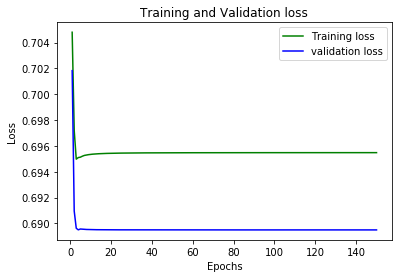

In [10]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing example for the loss function 

In [10]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([[[0.1, 0.5], [0.1, 0.5]], [[0.1, 0.5], [0.3, 0.5]], [[0.1, 0.5], [1.0, 1.0]]])
target = torch.tensor([[0, 0], [1, 1], [1, 1]])
output = loss(input, target)
output

tensor(0.5821)